##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [5]:
encoder = info.features['text'].encoder

In [6]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string n the batch:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compile the Keras model to configure the training process:

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 55s 141ms/step - loss: 0.6530 - accuracy: 0.5983 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 48s 124ms/step - loss: 0.3648 - accuracy: 0.8521 - val_loss: 0.3552 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 48s 124ms/step - loss: 0.2560 - accuracy: 0.9024 - val_loss: 0.3304 - val_accuracy: 0.8609
Epoch 4/10
391/391 [==============================] - 48s 123ms/step - loss: 0.2153 - accuracy: 0.9230 - val_loss: 0.3230 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 48s 123ms/step - loss: 0.1887 - accuracy: 0.9346 - val_loss: 0.3435 - val_accuracy: 0.8615
Epoch 6/10
391/391 [==============================] - 48s 123ms/step - loss: 0.1711 - accuracy: 0.9416 - val_loss: 0.3324 - val_accuracy: 0.8641
Epoch 7/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1452 - accuracy: 0.9524 - val_loss: 0.3489 

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 18s 46ms/step - loss: 0.4621 - accuracy: 0.8581
Test Loss: 0.46211091787232766
Test Accuracy: 0.8581200242042542


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [16]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [17]:
def sample_predict(sentence, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [18]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.41101742]]


In [19]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.4186573]]


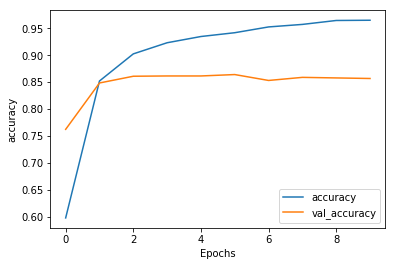

In [20]:
plot_graphs(history, 'accuracy')

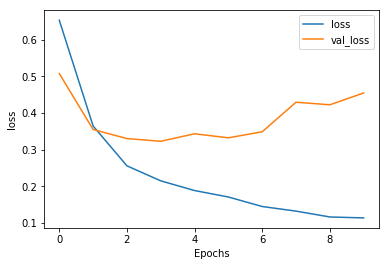

In [21]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 89s 228ms/step - loss: 0.6491 - accuracy: 0.5914 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 81s 207ms/step - loss: 0.3512 - accuracy: 0.8623 - val_loss: 0.3416 - val_accuracy: 0.8505
Epoch 3/10
391/391 [==============================] - 81s 207ms/step - loss: 0.2710 - accuracy: 0.9048 - val_loss: 0.3342 - val_accuracy: 0.8672
Epoch 4/10
391/391 [==============================] - 81s 208ms/step - loss: 0.2143 - accuracy: 0.9285 - val_loss: 0.3488 - val_accuracy: 0.8766
Epoch 5/10
391/391 [==============================] - 81s 206ms/step - loss: 0.1845 - accuracy: 0.9406 - val_loss: 0.3586 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 81s 207ms/step - loss: 0.1615 - accuracy: 0.9513 - val_loss: 0.3647 - val_accuracy: 0.8646
Epoch 7/10
391/391 [==============================] - 81s 207ms/step - loss: 0.1420 - accuracy: 0.9575 - val_loss: 0.4124 

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 34s 86ms/step - loss: 0.5185 - accuracy: 0.8543
Test Loss: 0.5184965819844505
Test Accuracy: 0.8543199896812439


In [26]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.05746633]]


In [27]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.01921545]]


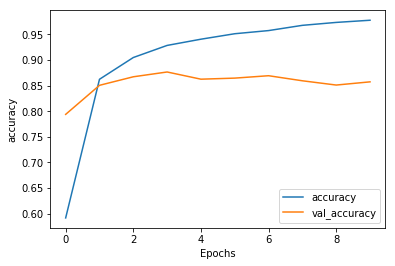

In [28]:
plot_graphs(history, 'accuracy')

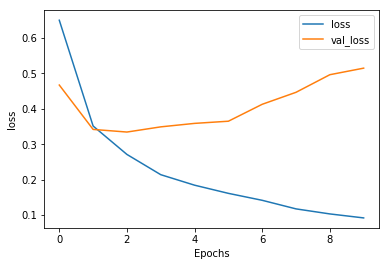

In [29]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
